In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

import json
from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet, UNet_conditional
from torchvision.transforms import v2
from matplotlib import pyplot as plt
from IPython.display import clear_output

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

with open("labels/pokedex.json") as json_data:
    data = json.load(json_data)

height = [float(str(d['profile']['height']).split()[0]) for d in data]
height = torch.tensor(height, device=device)
#height

types = [d['type'] for d in data]
all_types = list(set([d[0] for d in types]))

def get_index(tp):
    if len(tp) == 1:
        return all_types.index(tp[0]), len(all_types)
    return all_types.index(tp[0]), all_types.index(tp[1])

types = torch.tensor([get_index(t) for t in types], device=device)

contour = load_contour().to(device)
contour.shape

torch.Size([3, 386, 1, 64, 64])

In [2]:
T = 500
beta = torch.linspace(0.005, 0.03, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0001, device='cuda:0')

In [3]:
alpha_

tensor([9.9500e-01, 9.8998e-01, 9.8493e-01, 9.7985e-01, 9.7476e-01, 9.6964e-01,
        9.6450e-01, 9.5934e-01, 9.5416e-01, 9.4896e-01, 9.4374e-01, 9.3850e-01,
        9.3324e-01, 9.2797e-01, 9.2268e-01, 9.1737e-01, 9.1205e-01, 9.0671e-01,
        9.0136e-01, 8.9599e-01, 8.9062e-01, 8.8523e-01, 8.7982e-01, 8.7441e-01,
        8.6899e-01, 8.6356e-01, 8.5811e-01, 8.5266e-01, 8.4720e-01, 8.4173e-01,
        8.3626e-01, 8.3078e-01, 8.2530e-01, 8.1980e-01, 8.1431e-01, 8.0881e-01,
        8.0331e-01, 7.9780e-01, 7.9229e-01, 7.8678e-01, 7.8127e-01, 7.7576e-01,
        7.7025e-01, 7.6474e-01, 7.5923e-01, 7.5372e-01, 7.4822e-01, 7.4271e-01,
        7.3721e-01, 7.3172e-01, 7.2623e-01, 7.2074e-01, 7.1526e-01, 7.0978e-01,
        7.0431e-01, 6.9885e-01, 6.9340e-01, 6.8795e-01, 6.8251e-01, 6.7708e-01,
        6.7166e-01, 6.6625e-01, 6.6085e-01, 6.5546e-01, 6.5008e-01, 6.4471e-01,
        6.3936e-01, 6.3401e-01, 6.2868e-01, 6.2337e-01, 6.1806e-01, 6.1278e-01,
        6.0750e-01, 6.0224e-01, 5.9700e-

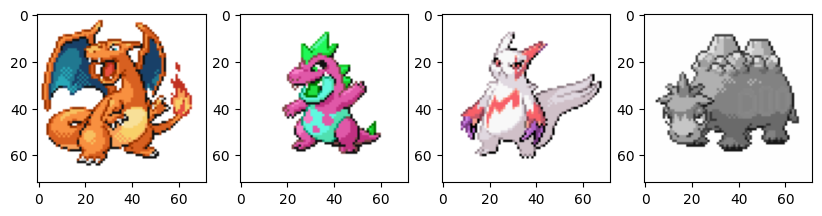

In [4]:
transform = v2.Compose([
    v2.Pad(6, 1.0),
    v2.RandomCrop((64+6, 64+6)),
    v2.Pad(1, 1.0),
    v2.RandomApply([v2.ColorJitter()], 0.1),
    v2.RandomApply([v2.RandomChannelPermutation()], 0.1),
    v2.RandomGrayscale(p = 0.1),
])

source = randint(0, 2)
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([transform(x) for x in x0], dim=0)

fig, axes = plt.subplots(1, 4, figsize=(10, 10))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
def isigmoid(x):
    eps = 0.05
    return torch.log(x + eps) - torch.log(1 - x + eps)

In [6]:
model = UNet_conditional(3, 3, time_dim=512, num_classes=len(all_types) + 1).to(device)

@torch.no_grad
def generate_image():
    model.eval()

    N = 3

    x = torch.randn((N, 3, 72, 72), device=device)

    ty = [["Grass", "Poison"], ["Fire", "Water"], ["Water"]]
    ty = torch.tensor([get_index(t) for t in ty], device=device)
    
    for t in reversed(range(T)):
        tt = torch.tensor([t] * N, device=device)

        z = torch.randn_like(x)
        if t == 0:
            z *= 0

        #x0 = model(x, tt)
        #x = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * z

        e = model(x, tt, ty) * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])
        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])

        #clear_output(wait=True)
        #fig, axes = plt.subplots(1, N, figsize=(10, 10))
        #for i in range(N):
        #    plot_image(torch.sigmoid(x)[i], axes[i])
        #plt.show()

    x = torch.sigmoid(x)
    
    fig, axes = plt.subplots(1, N, figsize=(10, 10))
    for i in range(N):
        plot_image(x[i], axes[i])
    plt.show()

    model.train()

In [7]:
#sd = torch.load("model.pt")
#model.load_state_dict(sd)

#generate_image()

  0%|          | 0/100001 [00:00<?, ?it/s]

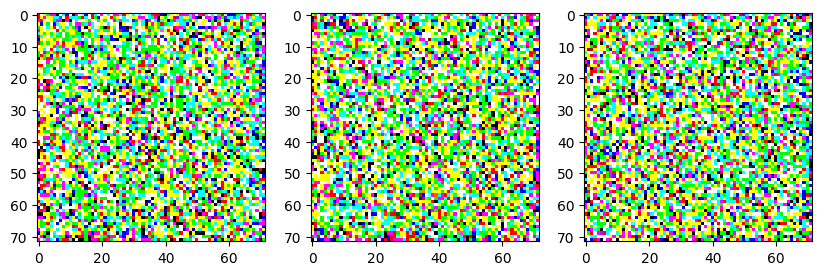

0.04228572:   1%|          | 997/100001 [00:34<51:43, 31.90it/s]  

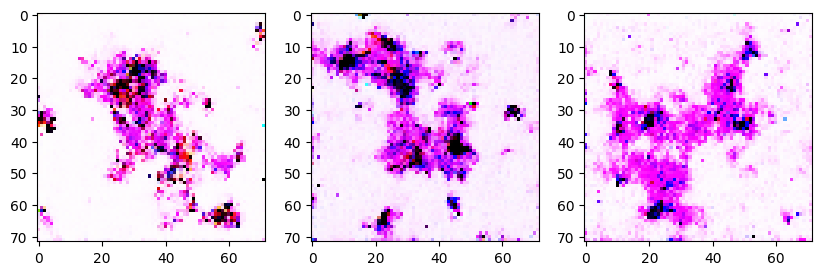

0.08881571:   2%|▏         | 1997/100001 [01:09<51:08, 31.94it/s]  

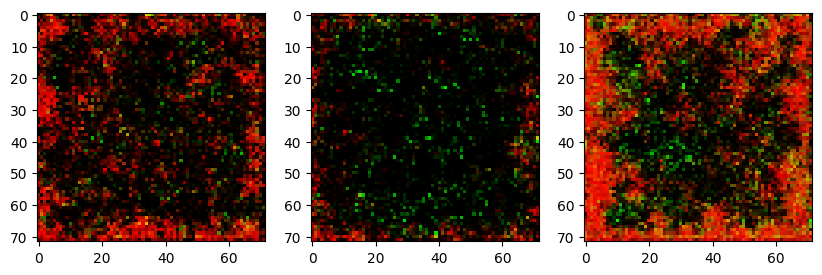

0.06359626:   3%|▎         | 2997/100001 [01:43<50:40, 31.90it/s]  

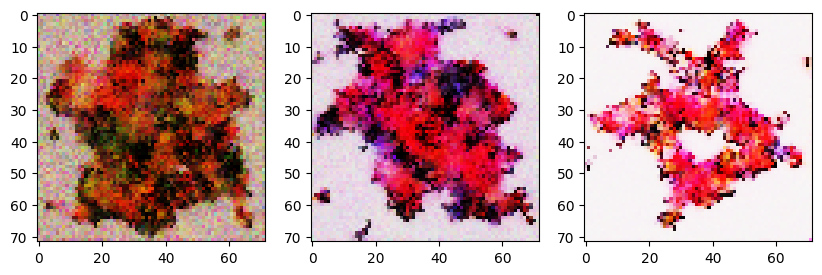

0.02047582:   4%|▍         | 3997/100001 [02:18<50:31, 31.67it/s]  

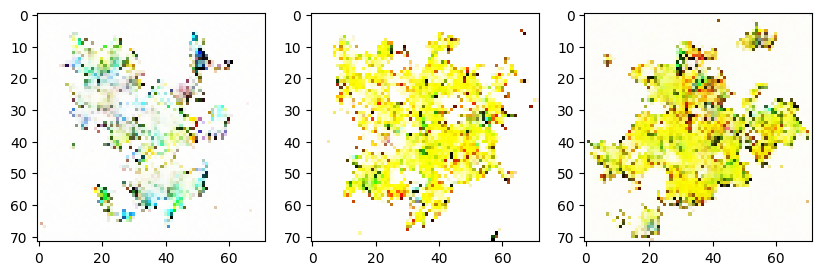

0.03462454:   5%|▍         | 4997/100001 [02:52<49:31, 31.97it/s]  

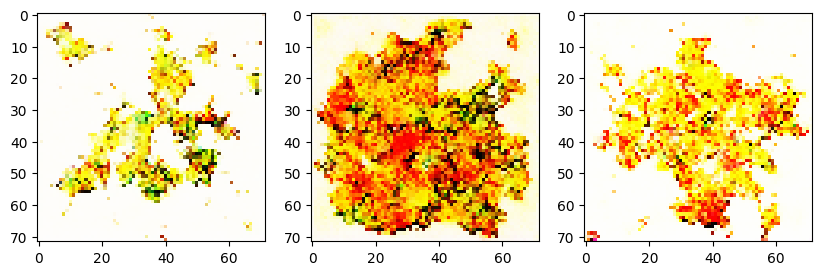

0.04485769:   6%|▌         | 5997/100001 [03:27<49:11, 31.85it/s]  

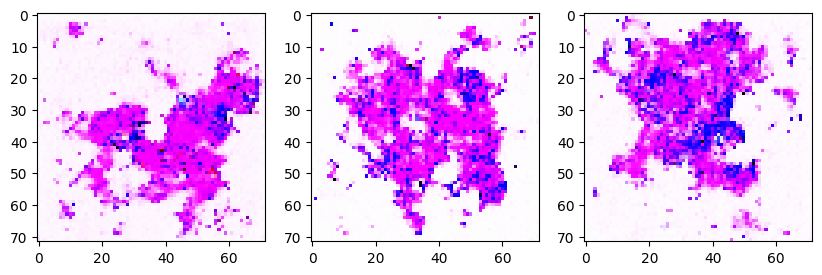

0.02988825:   7%|▋         | 6997/100001 [04:02<48:40, 31.85it/s]  

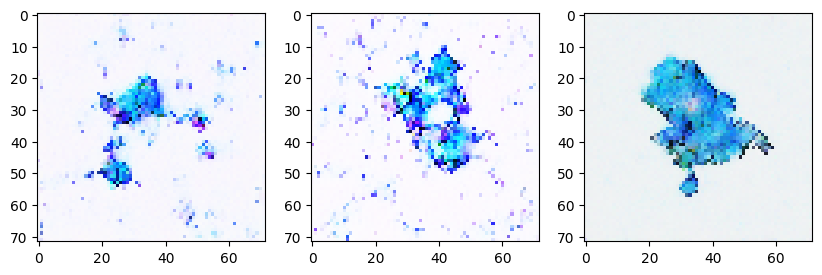

0.03634448:   8%|▊         | 7997/100001 [04:36<48:03, 31.91it/s]  

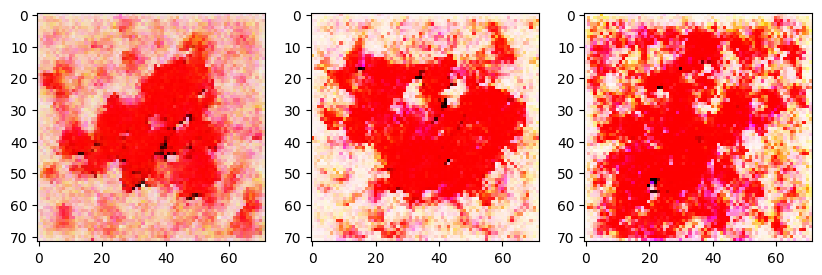

0.03524381:   9%|▉         | 8997/100001 [05:11<47:29, 31.94it/s]  

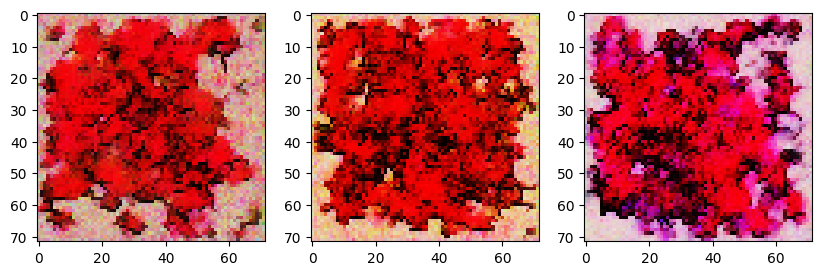

0.04506402:  10%|▉         | 9997/100001 [05:45<47:02, 31.89it/s]  

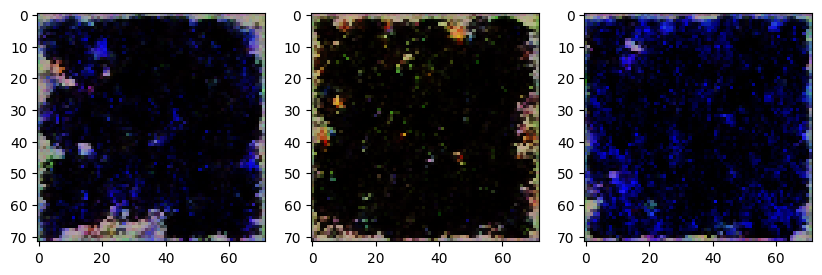

0.02033112:  11%|█         | 10997/100001 [06:20<46:33, 31.86it/s]  

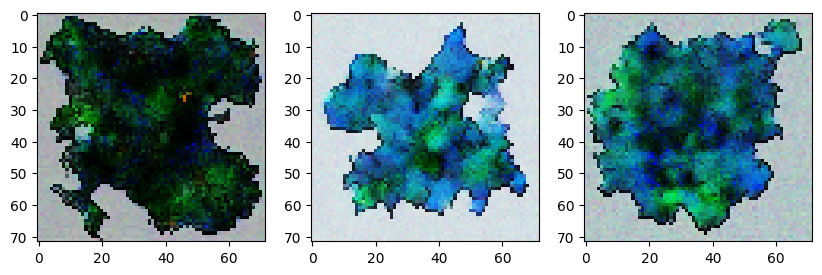

0.03270510:  12%|█▏        | 11997/100001 [06:55<46:01, 31.86it/s]  

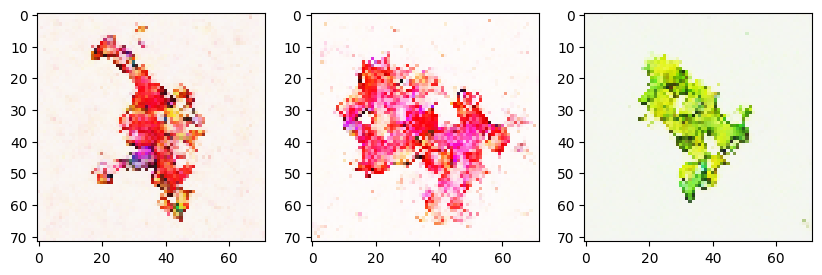

0.02691873:  13%|█▎        | 12997/100001 [07:29<45:33, 31.83it/s]  

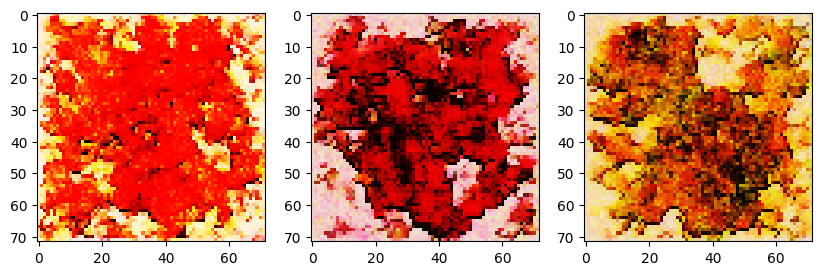

0.04388843:  14%|█▍        | 13997/100001 [08:04<45:01, 31.83it/s]  

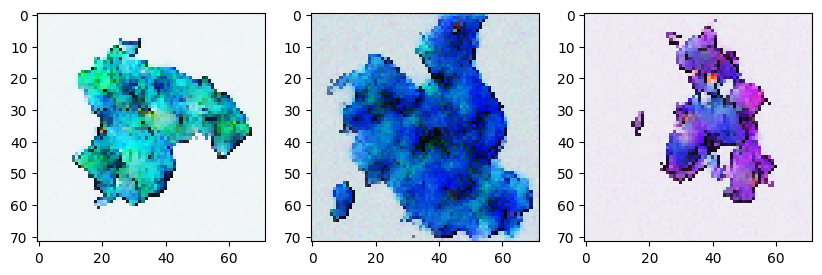

0.02740418:  15%|█▍        | 14997/100001 [08:39<44:32, 31.81it/s]  

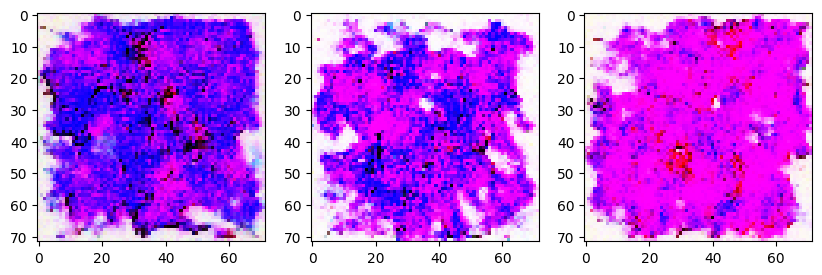

0.01001005:  16%|█▌        | 15997/100001 [09:13<44:07, 31.73it/s]  

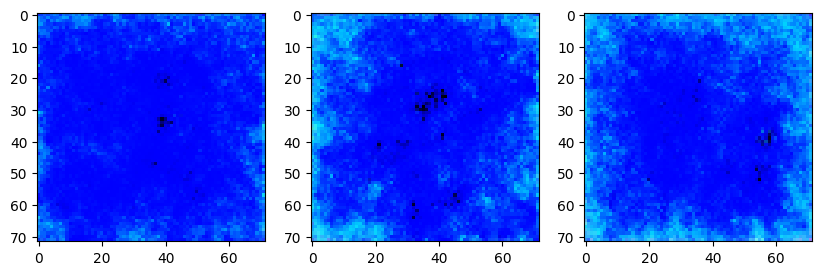

0.01675840:  17%|█▋        | 16997/100001 [09:48<43:26, 31.85it/s]  

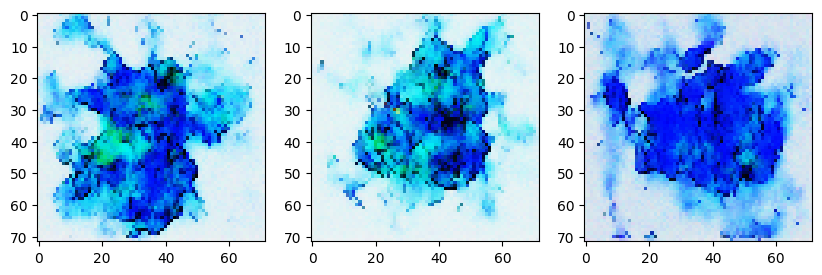

0.02442141:  18%|█▊        | 17997/100001 [10:23<42:57, 31.82it/s]  

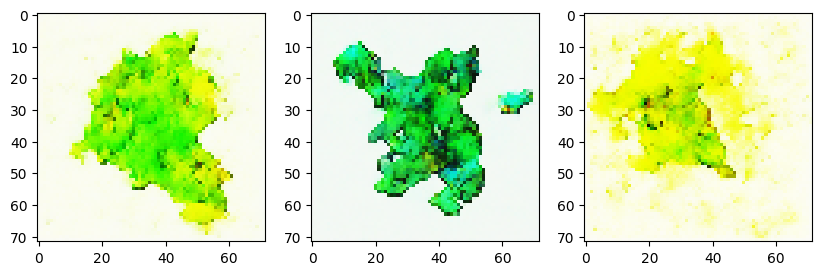

0.03196834:  19%|█▉        | 18997/100001 [10:57<42:22, 31.86it/s]  

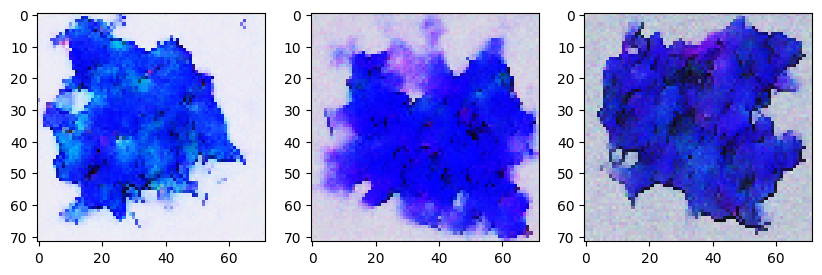

0.05139942:  20%|█▉        | 19997/100001 [11:32<41:45, 31.93it/s]  

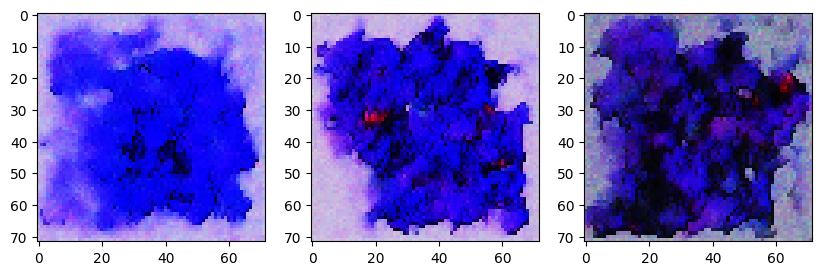

0.02313719:  21%|██        | 20997/100001 [12:06<41:15, 31.92it/s]  

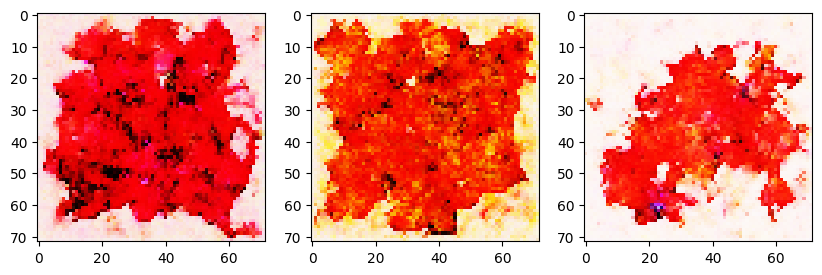

0.01566441:  22%|██▏       | 21997/100001 [12:41<40:50, 31.83it/s]  

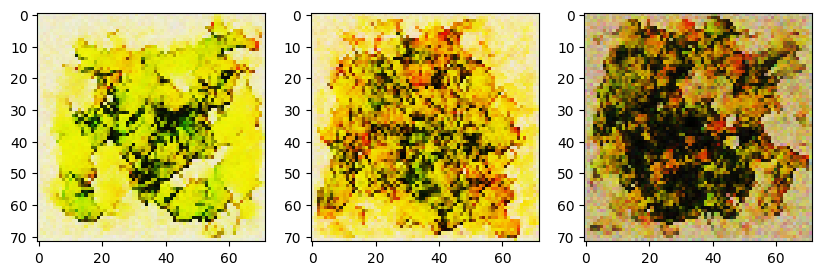

0.02350523:  23%|██▎       | 22997/100001 [13:16<40:18, 31.84it/s]  

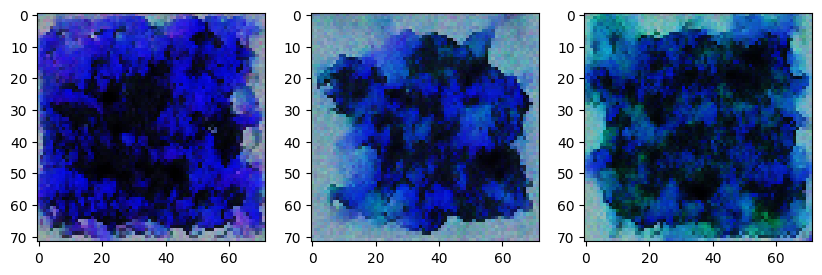

0.03730678:  24%|██▍       | 23997/100001 [13:50<39:45, 31.87it/s]  

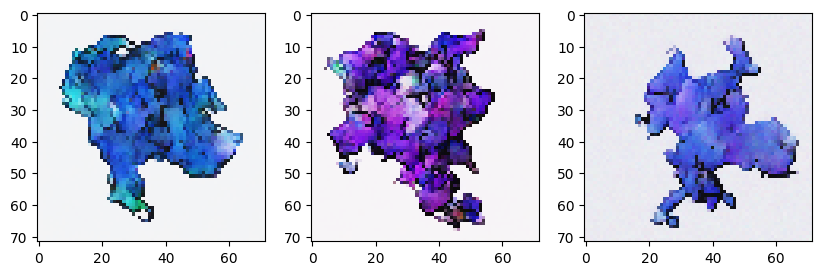

0.02777468:  25%|██▍       | 24997/100001 [14:25<39:13, 31.87it/s]  

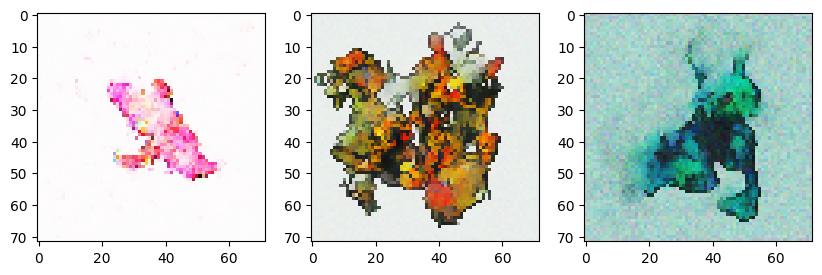

0.01387904:  26%|██▌       | 25997/100001 [15:00<38:45, 31.82it/s]  

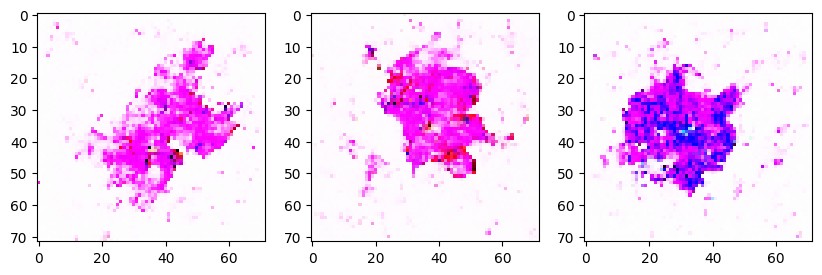

0.03690856:  27%|██▋       | 26997/100001 [15:34<38:12, 31.84it/s]  

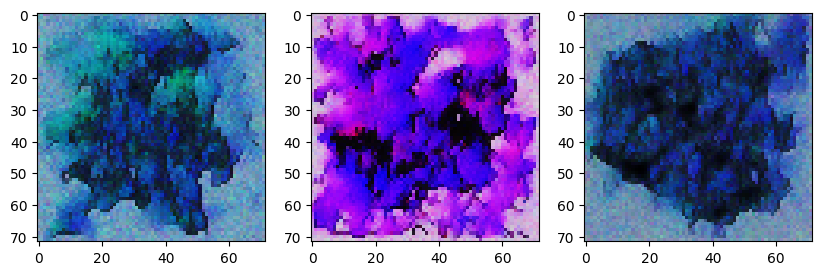

0.01797803:  28%|██▊       | 27997/100001 [16:09<37:44, 31.79it/s]  

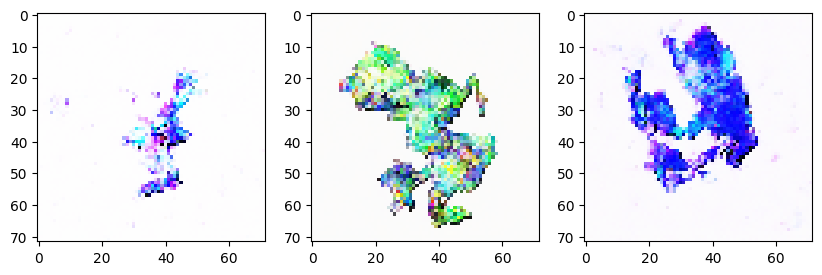

0.01842744:  29%|██▉       | 28997/100001 [16:43<37:03, 31.93it/s]  

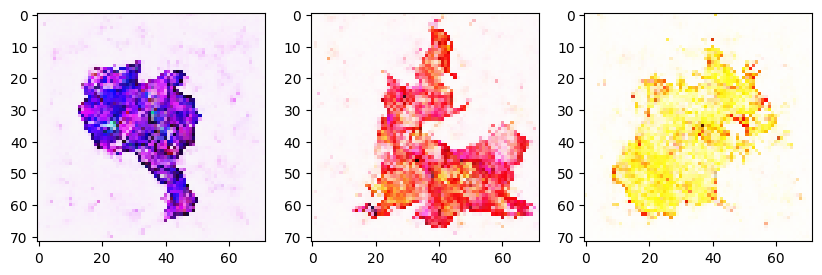

0.06214177:  30%|██▉       | 29997/100001 [17:18<36:41, 31.80it/s]  

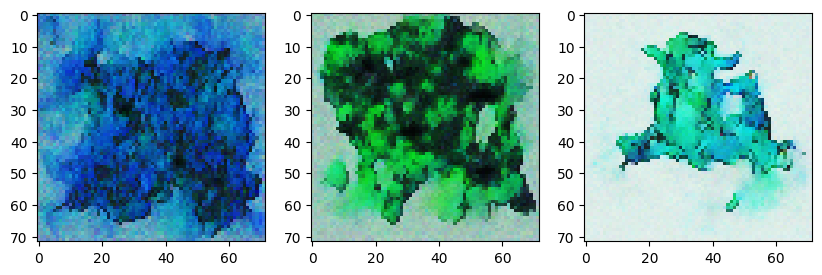

0.01975883:  31%|███       | 30997/100001 [17:53<36:10, 31.79it/s]  

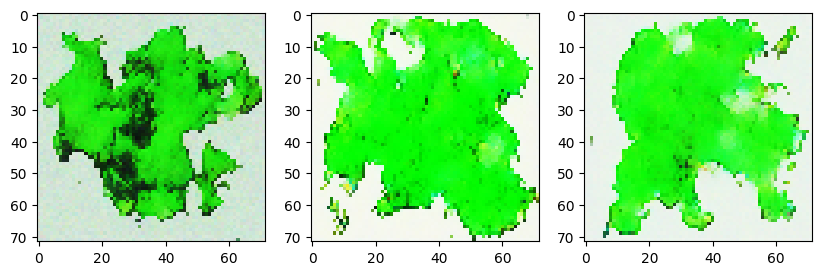

0.01735948:  32%|███▏      | 31997/100001 [18:27<35:32, 31.89it/s]  

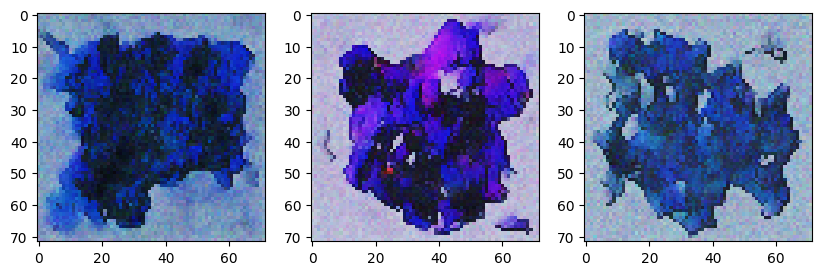

0.02383027:  33%|███▎      | 32997/100001 [19:02<35:06, 31.81it/s]  

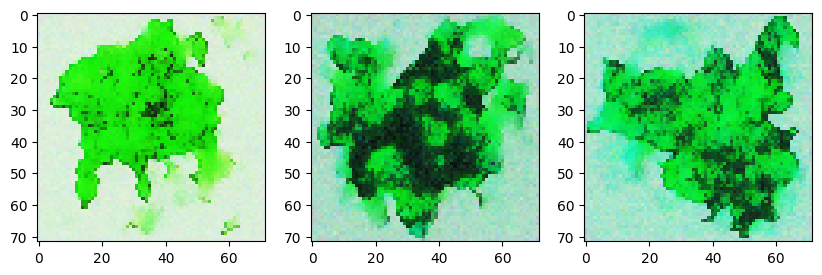

0.00796127:  34%|███▍      | 33997/100001 [19:37<34:30, 31.89it/s]  

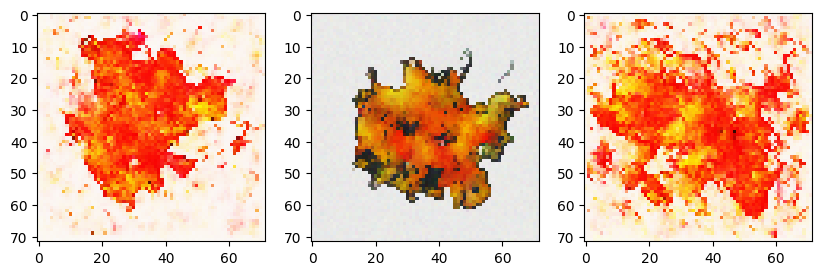

0.02616474:  35%|███▍      | 34997/100001 [20:11<34:01, 31.84it/s]  

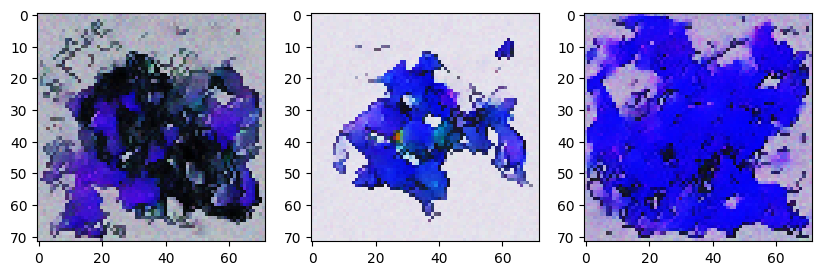

0.01419586:  36%|███▌      | 35997/100001 [20:46<33:24, 31.93it/s]  

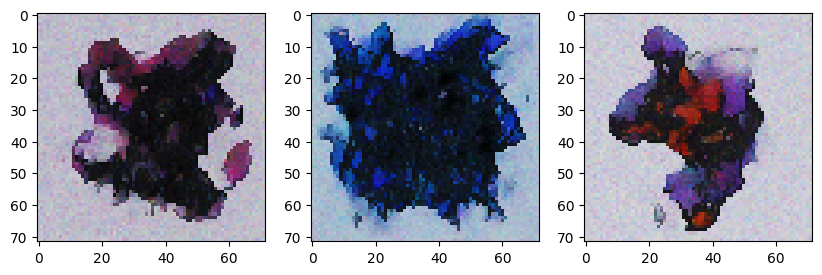

0.02645436:  37%|███▋      | 36997/100001 [21:21<32:55, 31.89it/s]  

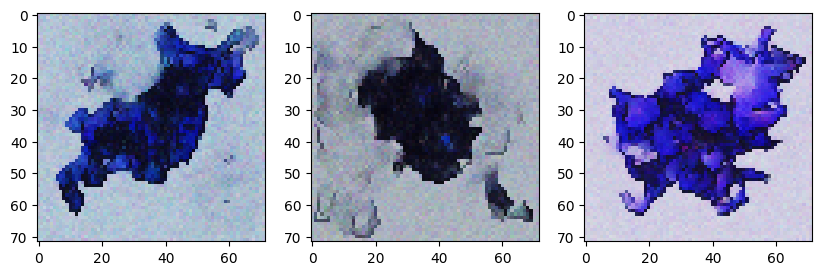

0.02366135:  38%|███▊      | 37997/100001 [21:55<32:22, 31.92it/s]  

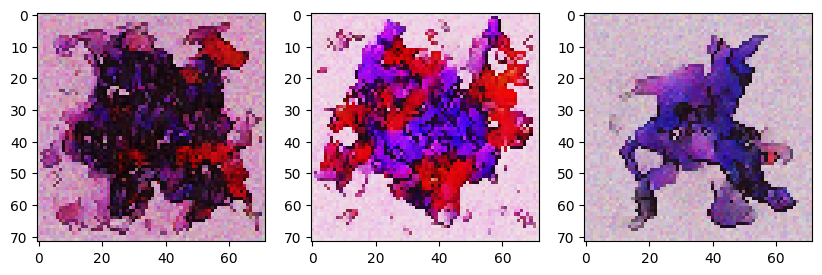

0.01952270:  39%|███▉      | 38997/100001 [22:30<31:53, 31.89it/s]  

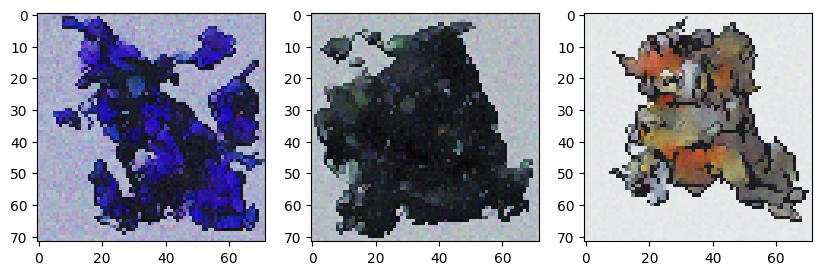

0.02652449:  40%|███▉      | 39997/100001 [23:04<31:24, 31.83it/s]  

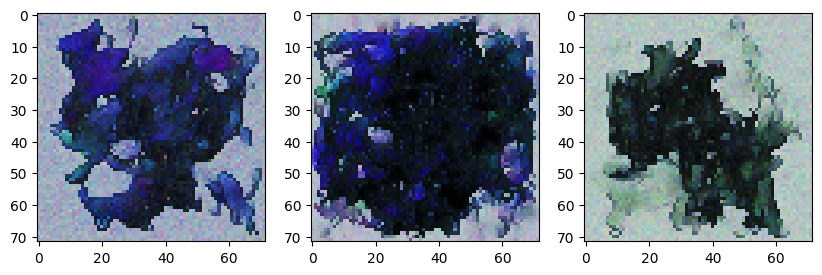

0.03660574:  41%|████      | 40997/100001 [23:39<30:53, 31.84it/s]  

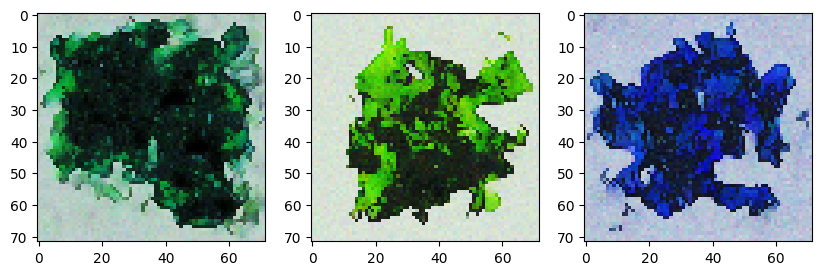

0.03433964:  42%|████▏     | 41997/100001 [24:14<30:22, 31.83it/s]  

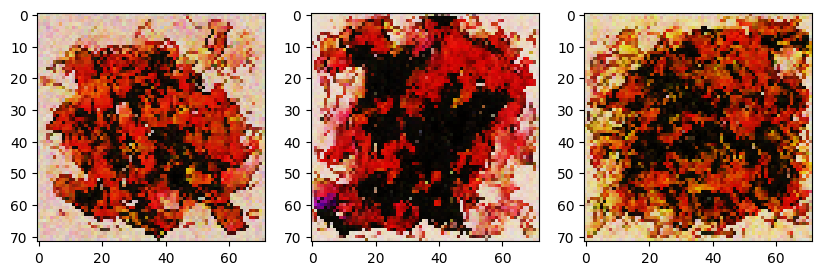

0.03852668:  43%|████▎     | 42997/100001 [24:48<29:58, 31.70it/s]  

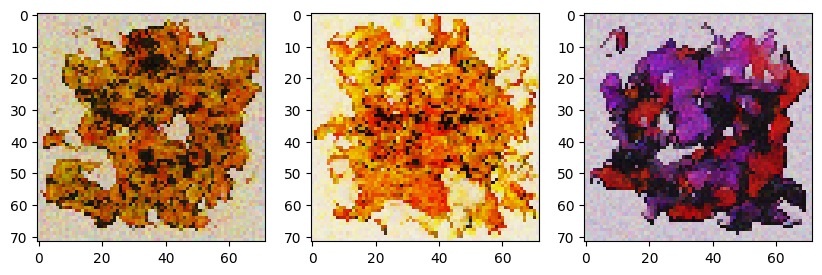

0.04662104:  44%|████▍     | 43997/100001 [25:23<29:17, 31.87it/s]  

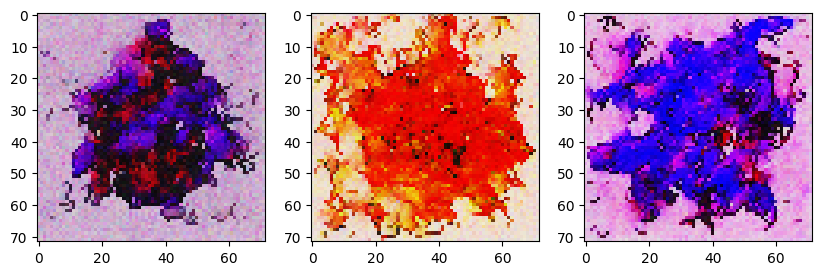

0.02465264:  45%|████▍     | 44997/100001 [25:58<28:53, 31.73it/s]  

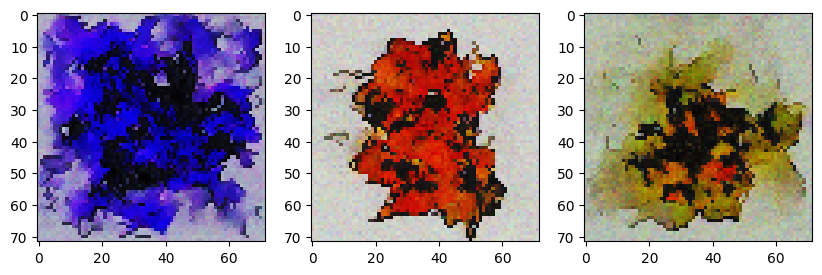

0.00998938:  46%|████▌     | 45997/100001 [26:32<28:12, 31.91it/s]  

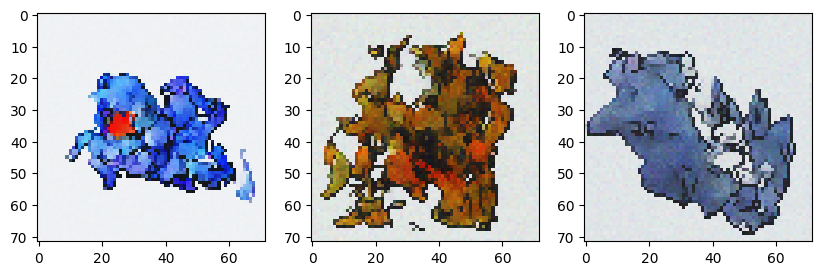

0.02207998:  47%|████▋     | 46997/100001 [27:07<27:41, 31.90it/s]  

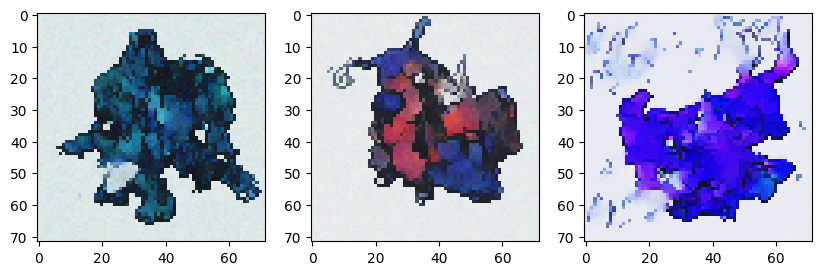

0.01332295:  48%|████▊     | 47997/100001 [27:41<27:12, 31.86it/s]  

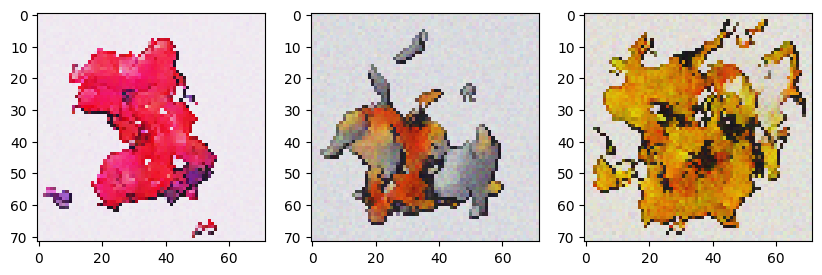

0.02140211:  49%|████▉     | 48997/100001 [28:16<26:40, 31.87it/s]  

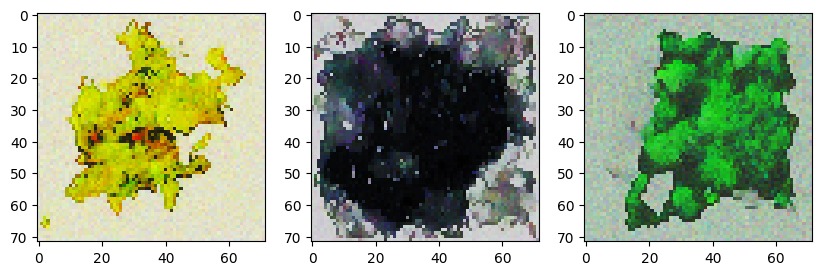

0.04132354:  50%|████▉     | 49997/100001 [28:51<26:09, 31.86it/s]  

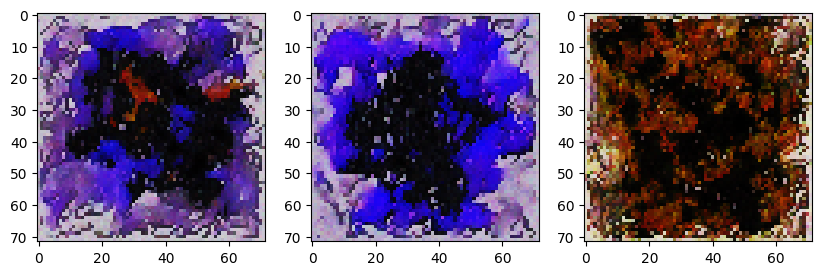

0.03898720:  51%|█████     | 50997/100001 [29:25<25:38, 31.85it/s]  

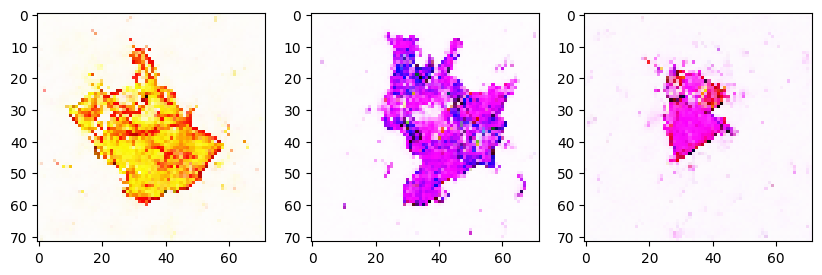

0.02238400:  52%|█████▏    | 51997/100001 [30:00<25:07, 31.85it/s]  

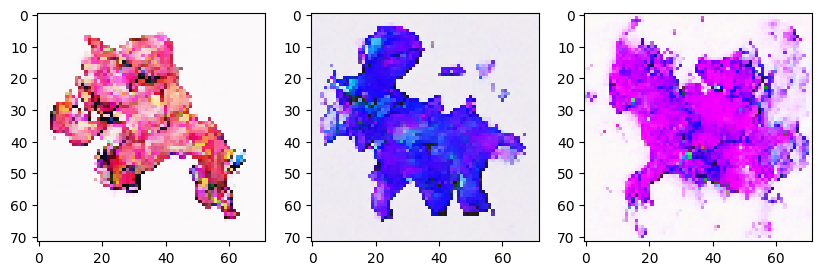

0.05262422:  53%|█████▎    | 52997/100001 [30:35<24:33, 31.89it/s]  

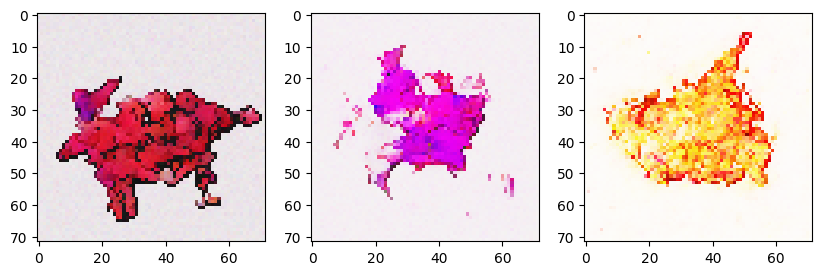

0.01223130:  54%|█████▍    | 53997/100001 [31:09<24:06, 31.80it/s]  

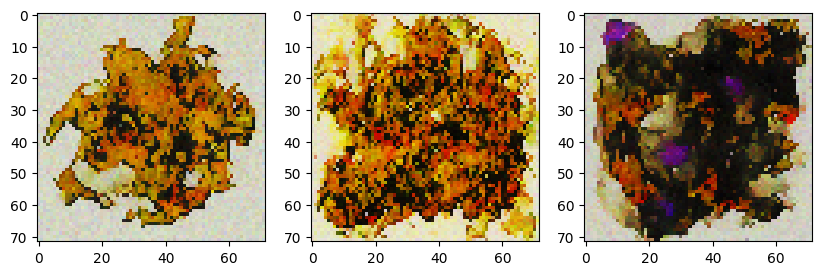

0.02237421:  55%|█████▍    | 54997/100001 [31:44<23:36, 31.76it/s]  

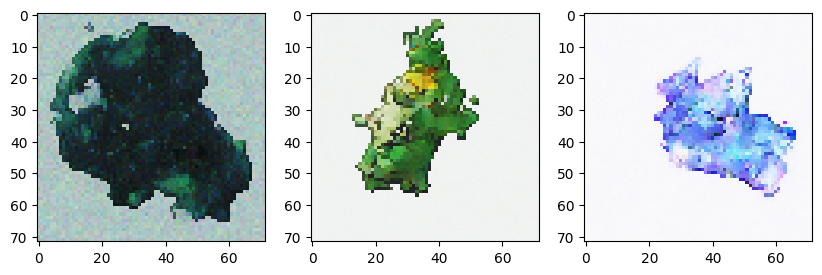

0.02211422:  56%|█████▌    | 55997/100001 [32:18<23:05, 31.76it/s]  

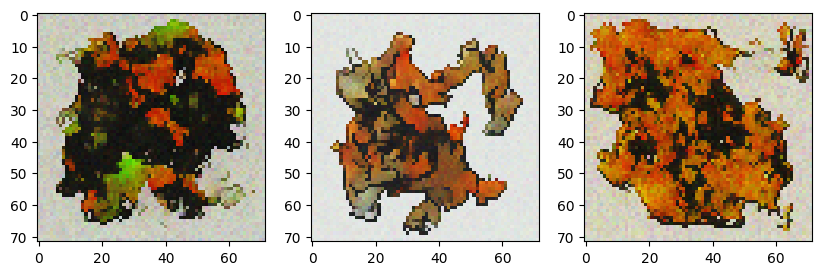

0.01743934:  57%|█████▋    | 56997/100001 [32:53<22:33, 31.76it/s]  

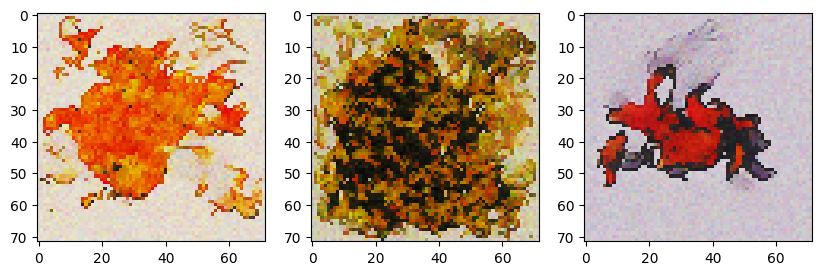

0.02212939:  58%|█████▊    | 57997/100001 [33:28<22:03, 31.75it/s]  

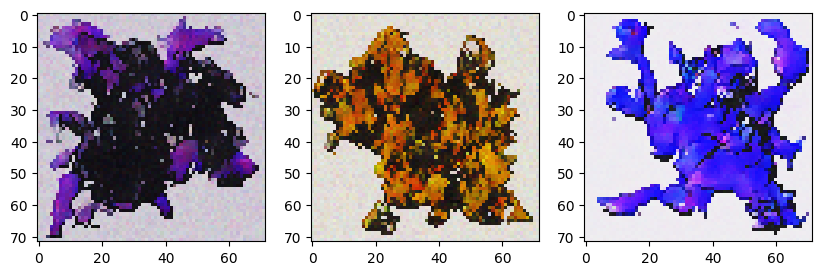

0.02033313:  59%|█████▉    | 58997/100001 [34:02<21:30, 31.77it/s]  

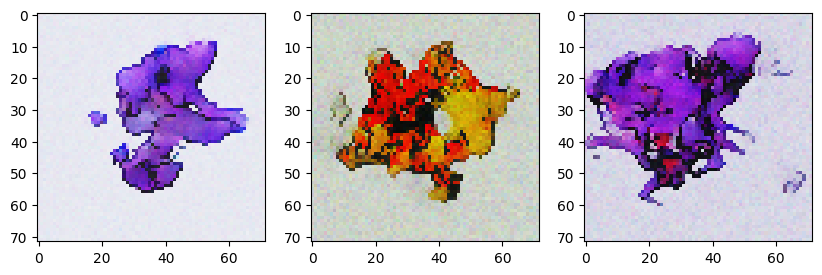

0.02272185:  60%|█████▉    | 59997/100001 [34:37<20:53, 31.92it/s]  

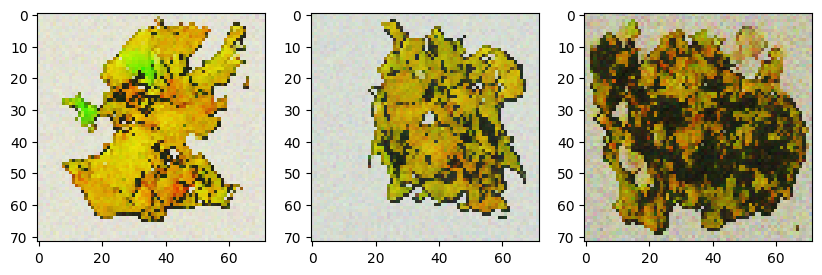

0.02008971:  61%|██████    | 60997/100001 [35:12<20:24, 31.85it/s]  

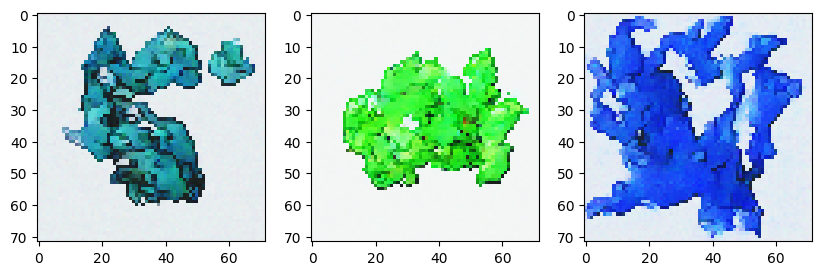

0.03033920:  62%|██████▏   | 61997/100001 [35:46<19:52, 31.86it/s]  

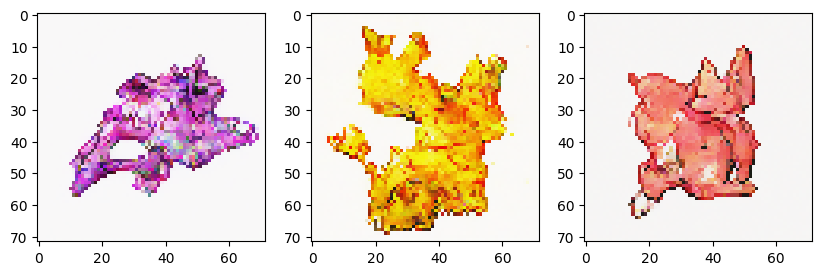

0.01868956:  63%|██████▎   | 62997/100001 [36:21<19:21, 31.85it/s]  

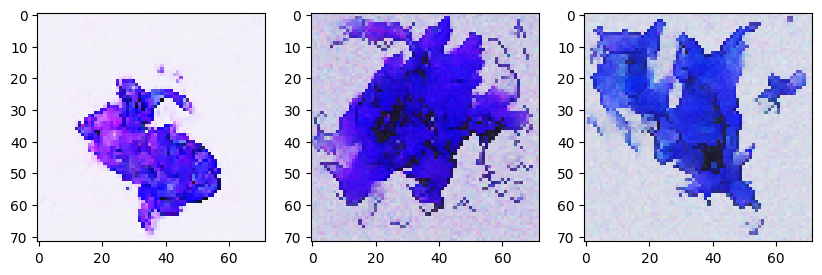

0.02518501:  64%|██████▍   | 63997/100001 [36:56<18:49, 31.88it/s]  

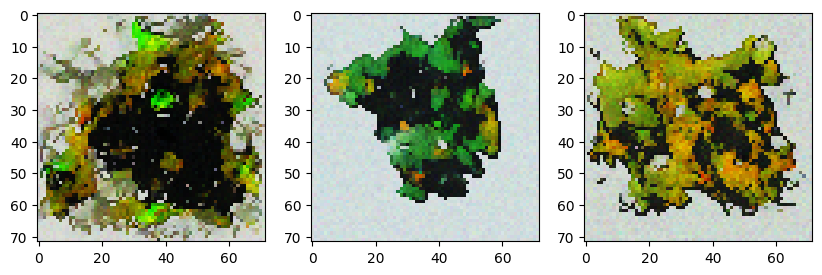

0.03346992:  65%|██████▍   | 64997/100001 [37:30<18:18, 31.88it/s]  

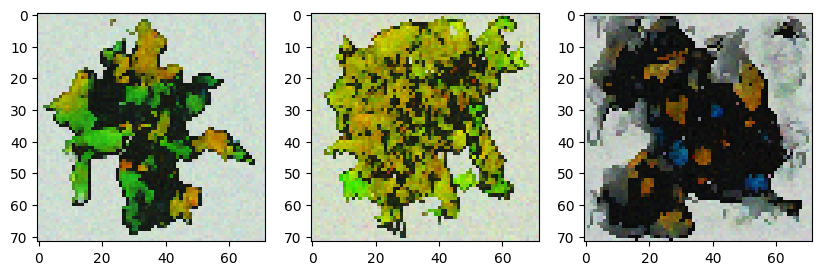

0.03187491:  66%|██████▌   | 65997/100001 [38:05<17:44, 31.95it/s]  

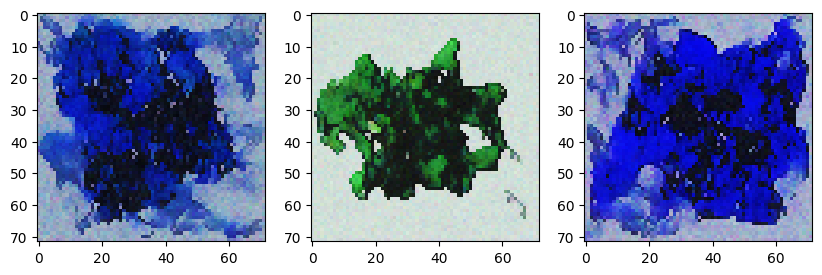

0.03531450:  67%|██████▋   | 66997/100001 [38:39<17:16, 31.83it/s]  

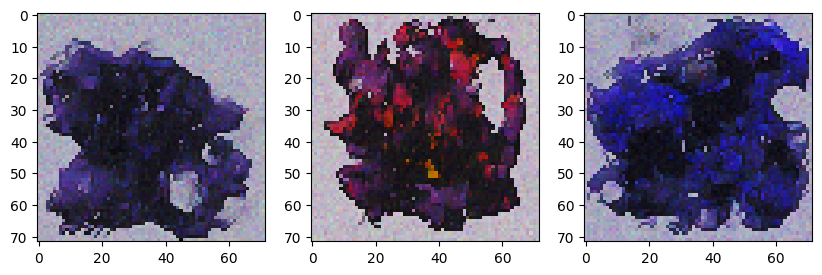

0.01957298:  68%|██████▊   | 67997/100001 [39:14<16:41, 31.94it/s]  

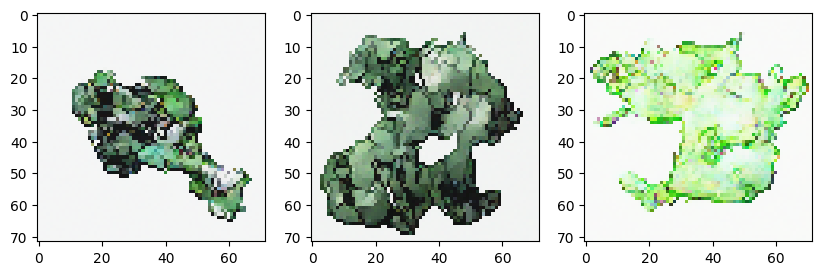

0.02485620:  69%|██████▉   | 68997/100001 [39:49<16:14, 31.82it/s]  

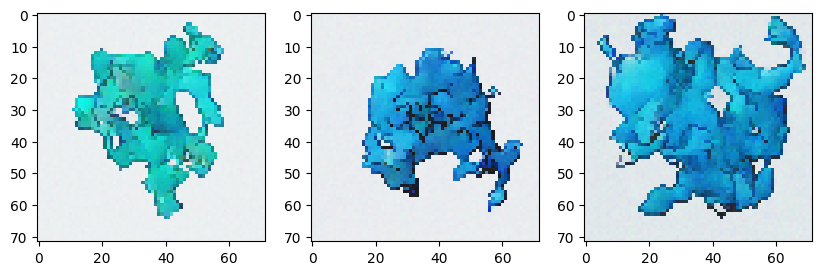

0.01885007:  70%|██████▉   | 69997/100001 [40:23<15:54, 31.43it/s]  

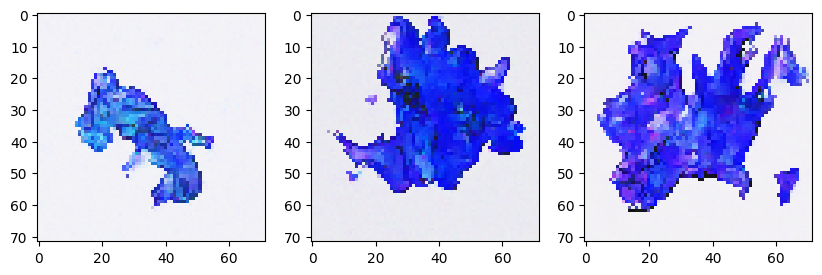

0.01256355:  71%|███████   | 70997/100001 [40:58<15:15, 31.68it/s]  

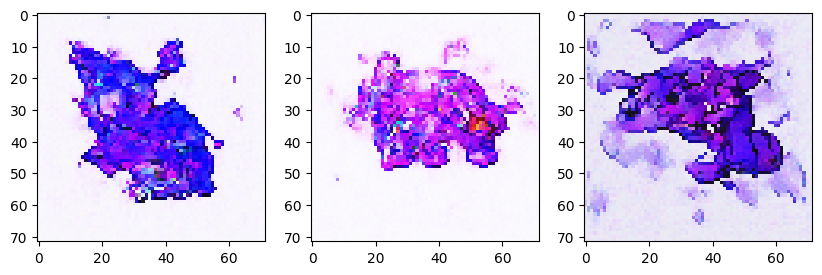

0.03022047:  72%|███████▏  | 71997/100001 [41:33<14:40, 31.82it/s]  

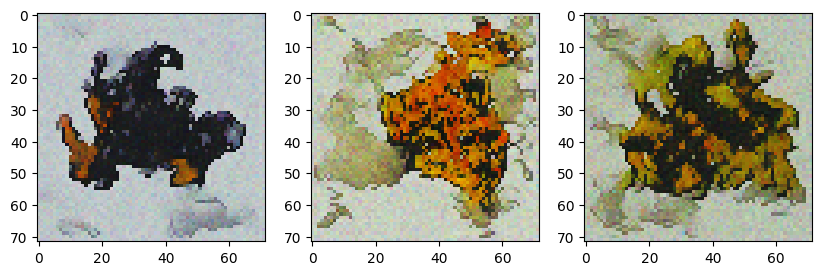

0.01272500:  73%|███████▎  | 72997/100001 [42:07<14:07, 31.88it/s]  

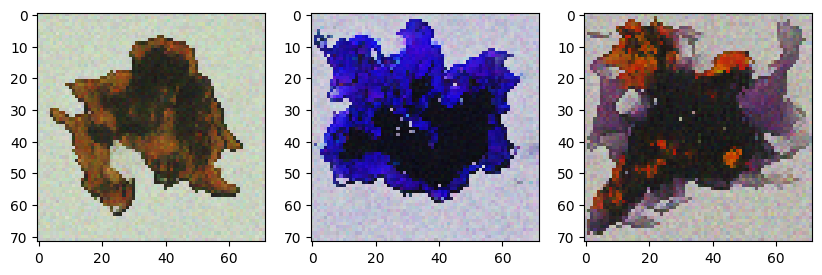

0.02307303:  74%|███████▍  | 73997/100001 [42:42<13:34, 31.92it/s]  

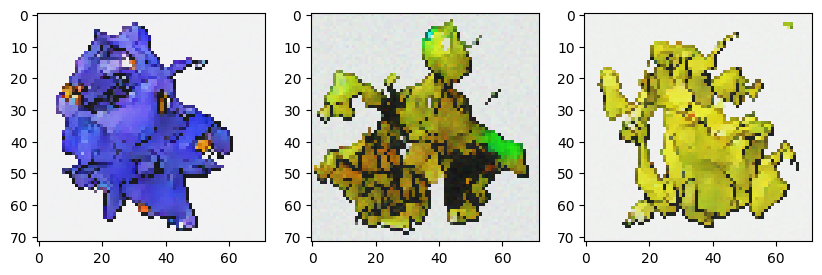

0.03073575:  75%|███████▍  | 74997/100001 [43:17<13:02, 31.96it/s]  

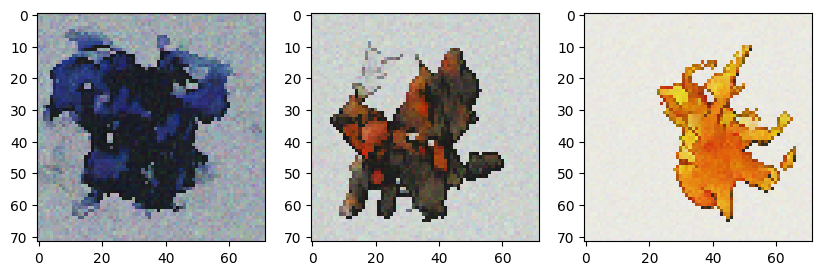

0.02815293:  76%|███████▌  | 75997/100001 [43:51<12:47, 31.26it/s]  

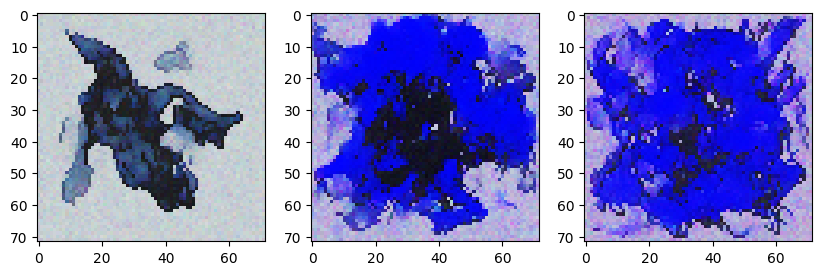

0.03824510:  77%|███████▋  | 76997/100001 [44:26<12:04, 31.73it/s]  

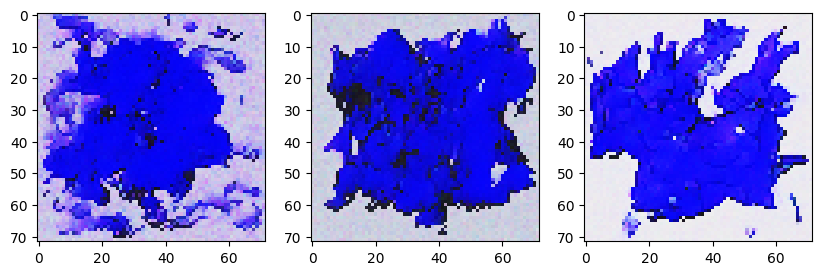

0.00914089:  78%|███████▊  | 77997/100001 [45:01<11:30, 31.85it/s]  

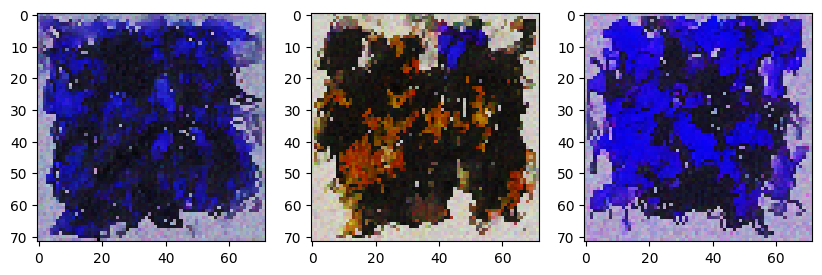

0.02428440:  79%|███████▉  | 78997/100001 [45:36<10:59, 31.83it/s]  

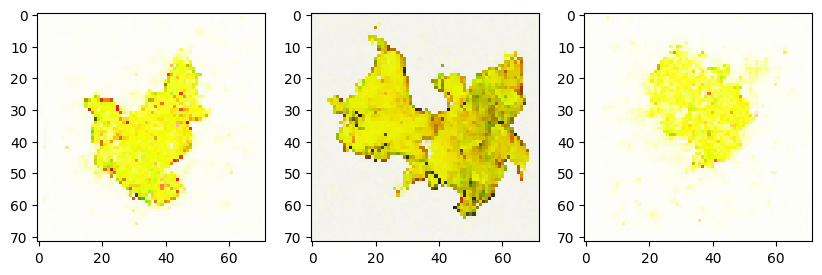

0.04234355:  80%|███████▉  | 79997/100001 [46:10<10:27, 31.90it/s]  

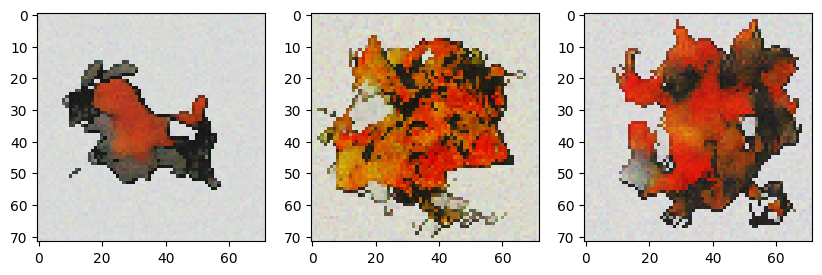

0.02074398:  81%|████████  | 80997/100001 [46:45<09:56, 31.87it/s]  

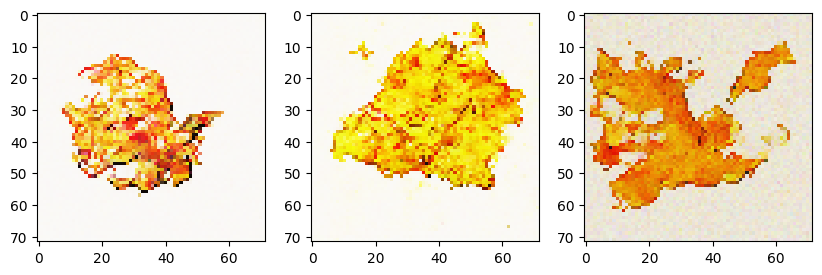

0.01530342:  82%|████████▏ | 81997/100001 [47:19<09:25, 31.84it/s]  

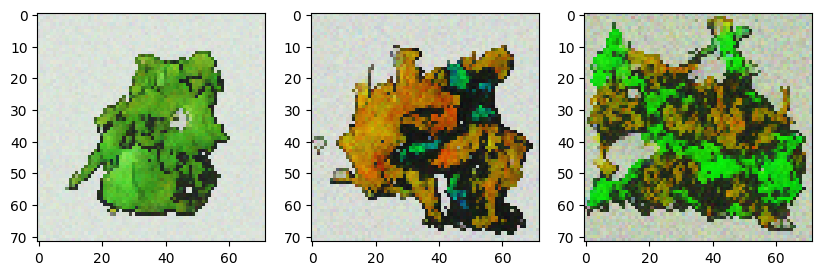

0.01741375:  83%|████████▎ | 82997/100001 [47:54<08:53, 31.87it/s]  

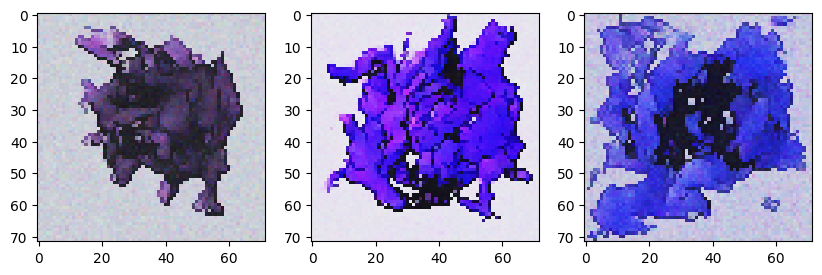

0.01556035:  84%|████████▍ | 83997/100001 [48:29<08:21, 31.92it/s]  

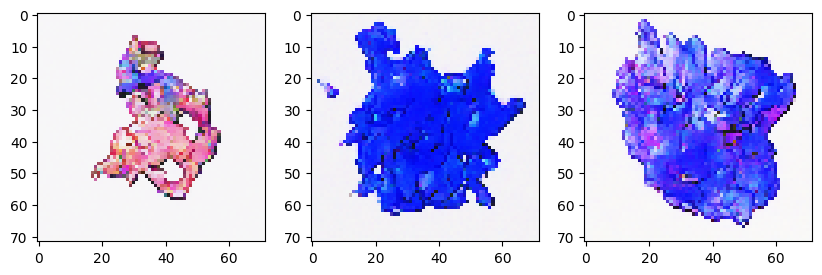

0.02236058:  85%|████████▍ | 84997/100001 [49:03<07:51, 31.84it/s]  

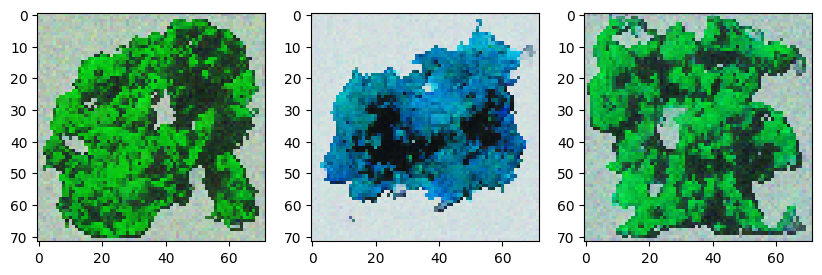

0.02718464:  86%|████████▌ | 85997/100001 [49:38<07:19, 31.83it/s]  

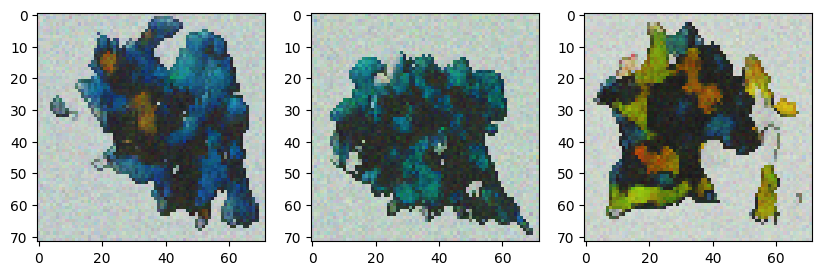

0.02956645:  87%|████████▋ | 86997/100001 [50:13<06:48, 31.86it/s]  

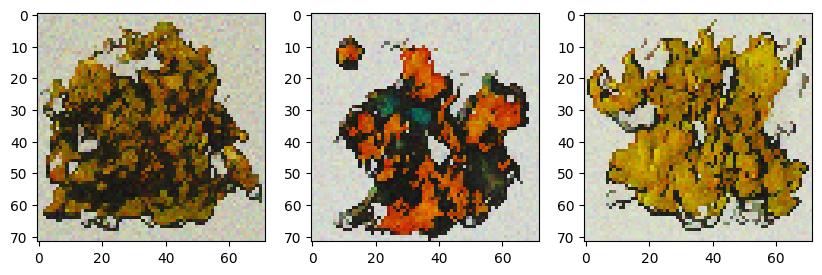

0.01456144:  88%|████████▊ | 87997/100001 [50:47<06:17, 31.83it/s]

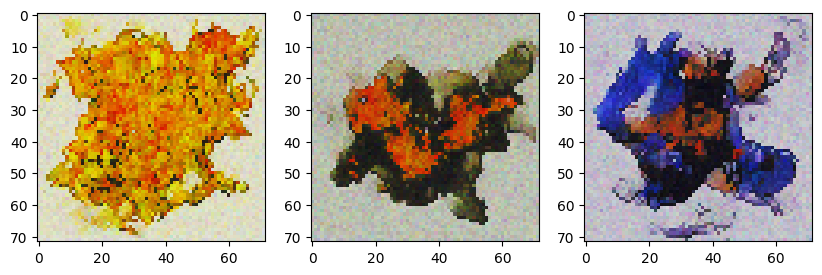

0.02298083:  89%|████████▉ | 88997/100001 [51:22<05:45, 31.89it/s]

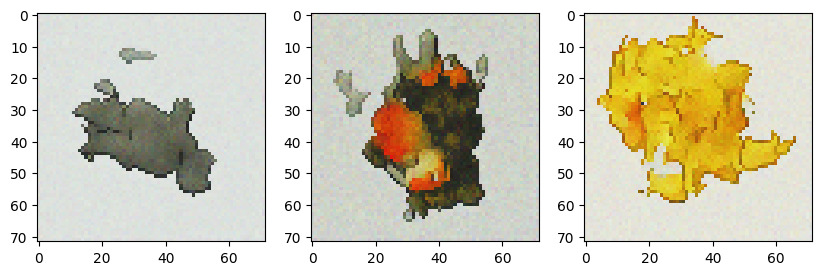

0.01442225:  90%|████████▉ | 89997/100001 [51:57<05:14, 31.83it/s]

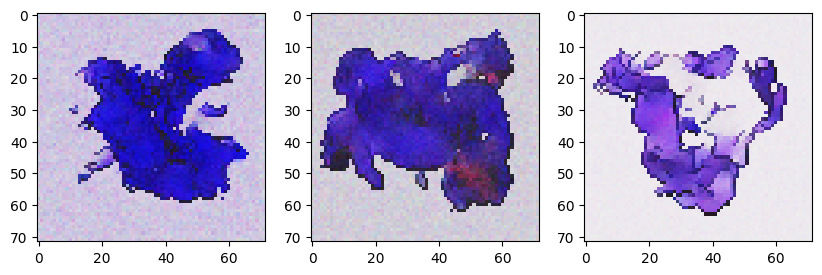

0.02225531:  91%|█████████ | 90997/100001 [52:31<04:42, 31.90it/s]

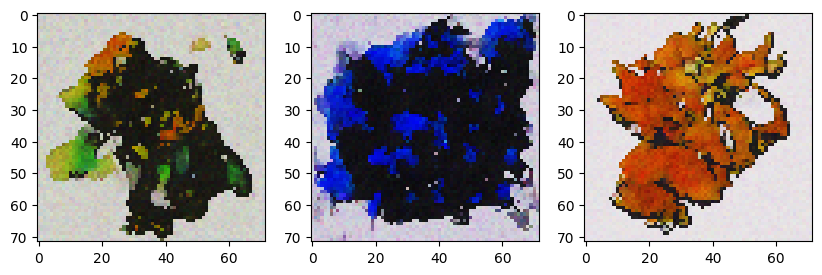

0.05235390:  92%|█████████▏| 91997/100001 [53:06<04:11, 31.85it/s]

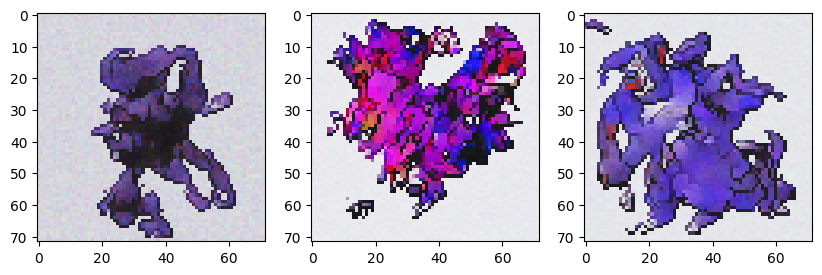

0.01886029:  93%|█████████▎| 92997/100001 [53:40<03:39, 31.94it/s]

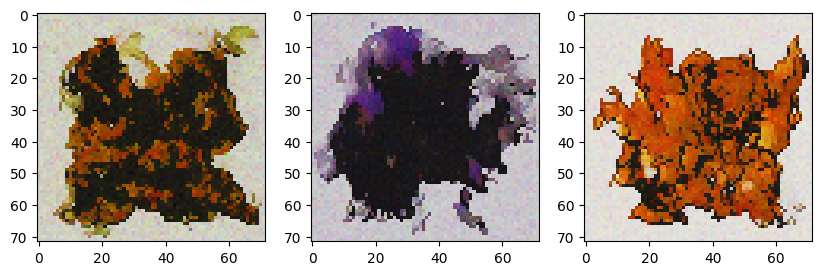

0.01558341:  94%|█████████▍| 93997/100001 [54:15<03:08, 31.86it/s]

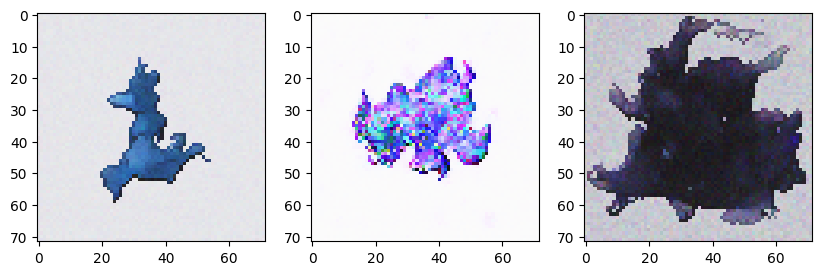

0.02767748:  95%|█████████▍| 94997/100001 [54:50<02:37, 31.81it/s]

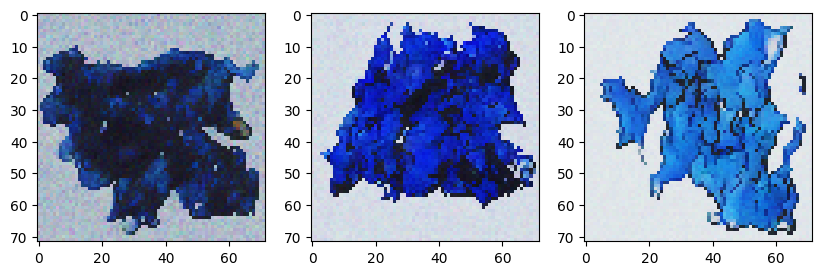

0.02363547:  96%|█████████▌| 95997/100001 [55:24<02:05, 31.93it/s]

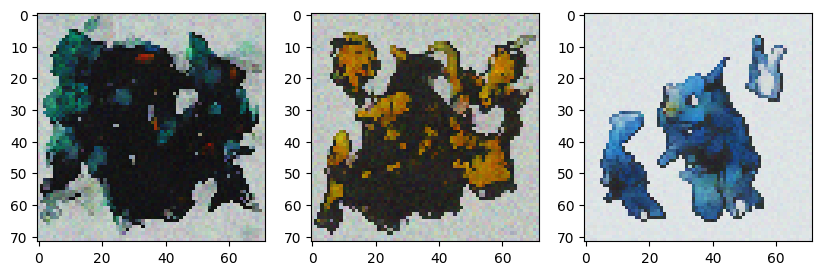

0.02236464:  97%|█████████▋| 96997/100001 [55:59<01:34, 31.75it/s]

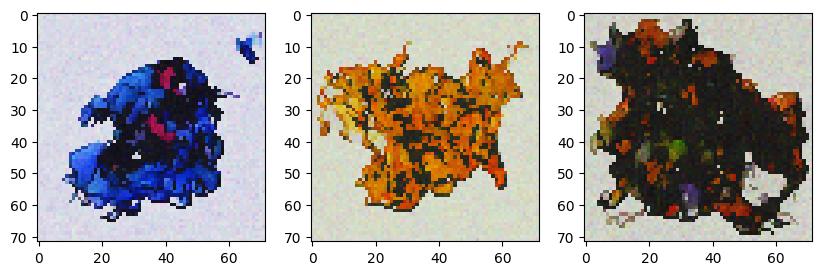

0.03496438:  98%|█████████▊| 97997/100001 [56:34<01:02, 31.91it/s]

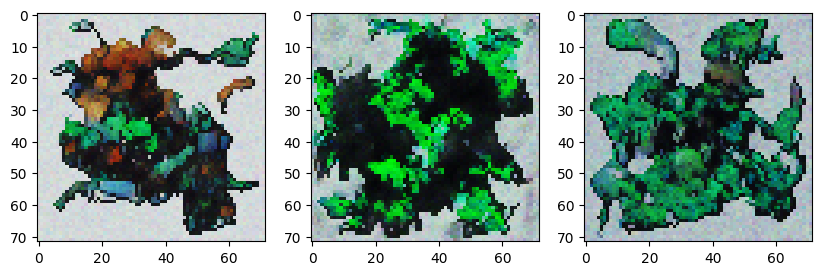

0.01877698:  99%|█████████▉| 98997/100001 [57:08<00:31, 31.93it/s]

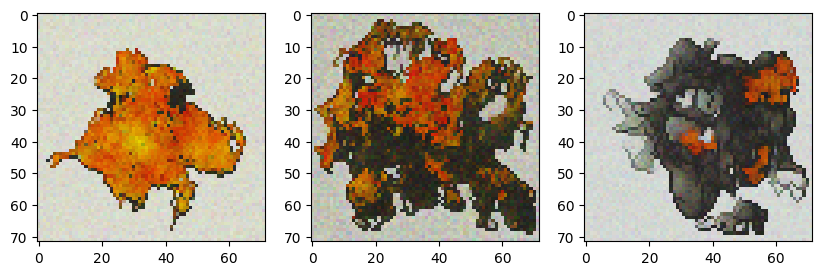

0.01195588: 100%|█████████▉| 99997/100001 [57:43<00:00, 31.60it/s]

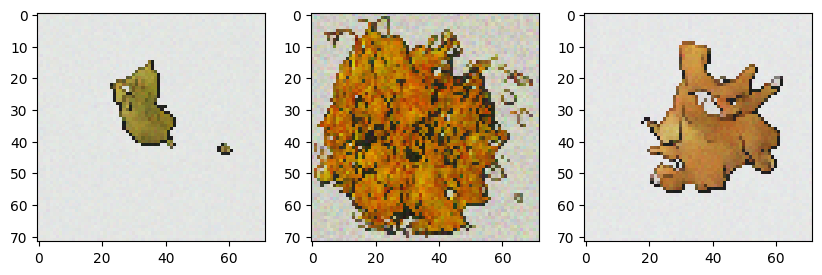

0.02169860: 100%|██████████| 100001/100001 [57:46<00:00, 28.85it/s]


In [8]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
pbar = tqdm(range(100001))
def closure():
    optimizer.zero_grad()

    bs = 8

    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]
    x0 = torch.stack([transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)

    ty = types[batch]
    
    e = torch.randn_like(x0)
    t = torch.randint(0, T - 1, (bs,), device=device)

    xt = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    ep = model(xt, t, ty)

    loss = loss_func(ep, e)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')